In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import pandas as pd
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import re
import torch
from torch.utils.data import DataLoader

In [47]:
# Load the dataset
file_path = '/content/drive/MyDrive/deeplearning/teampro/KHS_dataset.txt'
data = pd.read_csv(file_path, delimiter=',')

In [49]:
# Merge labels
label_columns = ['contain_gender_bias', 'bias', 'hate']
data['multi_class_label'] = data[label_columns].idxmax(axis=1)

# 텍스트 클리닝 함수
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z가-힣0-9\s]", "", text)
    return text.strip()

# 'comments' 열 클리닝
data['comments'] = data['comments'].apply(clean_text)

In [50]:
# Encode Label & Make label column
id2label = {k:v for k, v in enumerate(data['multi_class_label'].unique())}
label2id = {v:k for k, v in id2label.items()}

data['labels'] = data['multi_class_label'].map(label2id)

In [51]:
# Split and Make Dataset
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

In [52]:
# Tokenize Dataset
tokenizer = BertTokenizer.from_pretrained('snunlp/KR-BERT-char16424')
def tokenize_data(data):
    encoded = tokenizer(
        data['comments'],
        truncation=True
    )
    encoded['labels'] = data['labels']
    return encoded

tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/6316 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/790 [00:00<?, ? examples/s]

Map:   0%|          | 0/790 [00:00<?, ? examples/s]

In [53]:
# Load Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest'    # pad to longest sequence in batch
)

In [54]:
# Function to compute metrics
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

In [59]:
# Load arguments
training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=30,
        weight_decay=.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        evaluation_strategy='steps',
        eval_steps=300,
        save_strategy='steps',
        save_steps=300,
        logging_strategy='steps',
        logging_steps=500,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        lr_scheduler_type='cosine',
        warmup_ratio=0.1

    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [60]:
# Load & Train model


model =  AutoModelForSequenceClassification.from_pretrained('snunlp/KR-BERT-char16424', num_labels=3)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snunlp/KR-BERT-char16424 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1
300,No log,0.905756,0.572152,0.440617
600,0.927600,0.840607,0.613924,0.571920
900,0.927600,0.840290,0.615190,0.613154
1200,0.746200,0.858284,0.643038,0.620242
1500,0.494300,1.035713,0.629114,0.625797
1800,0.494300,1.458464,0.616456,0.600085
2100,0.242900,1.847010,0.615190,0.603906
2400,0.242900,2.055980,0.607595,0.592371
2700,0.132700,2.698377,0.596203,0.605560
3000,0.093100,2.694094,0.606329,0.597592


TrainOutput(global_step=11850, training_loss=0.12650917437006148, metrics={'train_runtime': 2549.8423, 'train_samples_per_second': 74.31, 'train_steps_per_second': 4.647, 'total_flos': 5487462606531528.0, 'train_loss': 0.12650917437006148, 'epoch': 30.0})

In [61]:
# Evaluate the final model on the test set
test_results = trainer.evaluate(tokenized_test_dataset)

print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")

Test Accuracy: 0.6088607594936709
Test F1 Score: 0.6046139059816634


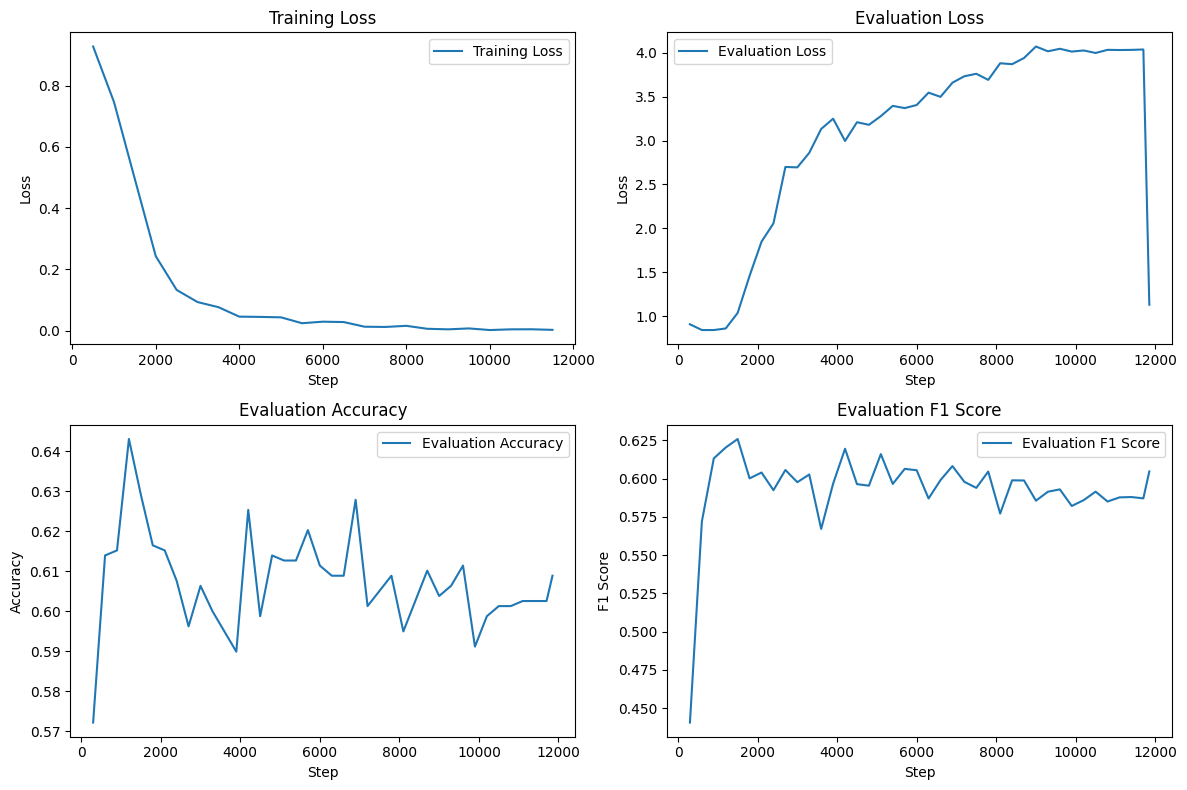

In [62]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Creating the plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(eval_steps, eval_f1, label='Evaluation F1 Score')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Evaluation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

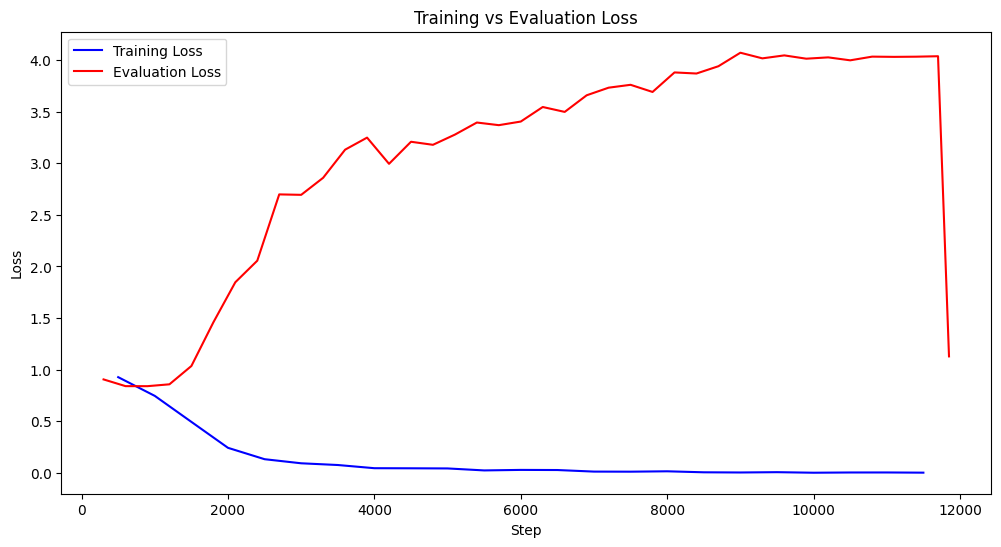

In [63]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Plotting Loss (Training and Evaluation on the same graph)
plt.figure(figsize=(12, 6))

plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
